This is the first try based on [this chatgpt conversation](https://chatgpt.com/g/g-p-683e32184df48191b142cd6042c183b4-tutor-atmospheric-science/c/6903d369-3be4-8329-bbde-0fc0355aed8e). It did not go that well. I started another attmempt in [this notebook](http://localhost:8888/lab/workspaces/cmpaign_2025_PMOD/tree/projecte/cmpaign_2025_PMOD/arts_getting_sarted.ipynb), where I try a more targeted conversation.

# Set up environment



Make a new environment(optional):
* conda create -n arts python=3.11 -y
* conda activate arts
* Make environment evailable to jupyter
  * mamba install ipykernel
  * python -m ipykernel install --user --name arts

Install pyarts
* mamba install -c rttools pyarts -y
  
Install hapi; don't use the conda version as it is out of date
* python -m pip install --upgrade hitran-api

# Test if arts is working

In [1]:
import pyarts, sys
from pyarts.workspace import Workspace
print("pyarts version:", getattr(pyarts, "__version__", "unknown"))
ws = Workspace()
print("Workspace OK:", ws is not None)

pyarts version: 2.6.16
Workspace OK: True


In [3]:
import numpy as np
from pyarts.workspace import Workspace

ws = Workspace()

# Example: set a small frequency grid around 930–950 nm (Hz)
c = 299792458.0
lam = np.linspace(930e-9, 950e-9, 11)         # 930–950 nm
f = c / lam                                   # convert to frequency
ws.f_grid = np.ascontiguousarray(f)           # direct assignment works

print("pyarts OK; f_grid length:", ws.f_grid.value.size)

# (Optional) run a standard controlfile if you have ARTS includes on your path:
# ws.execute_controlfile("general/general.arts")


pyarts OK; f_grid length: 11


# Lets first try out HAPI, the most simple approcimation

In [ ]:
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d
from scipy.constants import N_A
from hapi import db_begin, fetch, absorptionCoefficient_Voigt

# ----------------------------
# Spectral grid for 940-nm work
# ----------------------------
lam_center_nm = 940.0
lam_span_nm   = 20.0      # 930–950 nm window
dlam_nm       = 0.02      # ~0.02 nm spacing
lam_nm = np.arange(lam_center_nm - lam_span_nm/2,
                   lam_center_nm + lam_span_nm/2 + dlam_nm, dlam_nm)

# Convert to wavenumber [cm^-1] for HAPI
lam_m = lam_nm * 1e-9
wnum_cm = (1.0 / lam_m) / 100.0  # m^-1 -> cm^-1
numin, numax = float(wnum_cm.min()), float(wnum_cm.max())

# ----------------------------
# Atmos state (effective for Voigt widths)
# (For reference-grade: switch to layer-resolved later.)
# ----------------------------
T_K  = 288.0
P_hPa = 1013.25

# ----------------------------
# Grids for LUT
# ----------------------------
m_vals  = np.linspace(1.0, 5.0, 9)  # airmass 1..5
pw_vals = np.concatenate([np.linspace(0.1, 2.0, 20),
                          np.linspace(2.5, 6.0, 15)])  # PW [cm]

# ----------------------------
# Column conversion (correct)
#   1 cm PW = 10 kg/m^2
#   molecules/m^2 = (10/0.018)*N_A * PW_cm
# ----------------------------
COL_PER_CM_PW = (10.0 / 0.018) * N_A   # ≈ 3.346e26 molec/m^2 per cm PW

# ----------------------------
# Get HITRAN sigma(λ) for H2O main isotopologue
# ----------------------------
def sigma_m2_on_lambda(lam_nm, T=T_K, P=P_hPa):
    db_begin('hitran_db')                  # local cache
    fetch('H2O_930_950', 1, 1, numin, numax)  # molec_id=1 (H2O), iso_id=1 (1H2-16O)

    nu_grid, k_cm_inv = absorptionCoefficient_Voigt(
        SourceTables='H2O_930_950',
        Environment={'T': T, 'p': P},      # K, hPa
        HITRAN_units=True
    )
    # k = sigma * n   ->  sigma = k / n
    n_cm3 = 2.6867805e19 * (P/1013.25) * (273.15/T)     # molecules/cm^3
    sigma_cm2 = k_cm_inv / n_cm3                        # cm^2/molecule

    # Interpolate to our wavelength grid (monotonic in wavenumber)
    f = interp1d(nu_grid, sigma_cm2, kind='linear',
                 bounds_error=False, fill_value="extrapolate")
    sigma_cm2_on_wn = f(wnum_cm)
    return sigma_cm2_on_wn * 1e-4   # -> m^2/molecule

sigma_m2 = sigma_m2_on_lambda(lam_nm, T=T_K, P=P_hPa)   # [lambda]

# ----------------------------
# Build T_lambda(lambda, m, pw) and tau_lambda
# ----------------------------
# Broadcast shapes:
#   lambda: (L, 1, 1)
#   m:      (1, M, 1)
#   pw:     (1, 1, W)
L = lam_nm.size
M = m_vals.size
W = pw_vals.size

sigma_b = sigma_m2.reshape(L, 1, 1)
m_b     = m_vals.reshape(1, M, 1)
pw_b    = pw_vals.reshape(1, 1, W)

Ncol_vert = COL_PER_CM_PW * pw_b              # molecules/m^2
Ncol_slant = m_b * Ncol_vert                  # molecules/m^2 (slant)

tau_lambda = sigma_b * Ncol_slant             # unitless
T_lambda   = np.exp(-tau_lambda)

# ----------------------------
# Package into xarray Dataset
# ----------------------------
ds = xr.Dataset(
    data_vars=dict(
        T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
        tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
        sigma_m2=(('lambda_nm',), sigma_m2)
    ),
    coords=dict(
        lambda_nm=lam_nm,
        m=m_vals,
        pw_cm=pw_vals
    ),
    attrs=dict(
        desc="Spectral H2O-only direct-beam transmittance and optical depth around 940 nm.",
        spectroscopy="HITRAN via hitran-api (Voigt, line-only; no MT_CKD continuum).",
        T_K=T_K, P_hPa=P_hPa
    )
)

ds.to_netcdf("lut_940nm_spectral_HAPI_xr.nc")
print(ds)
print("Wrote lut_940nm_spectral_HAPI_xr.nc")


ds_hapi = ds

## for convolution

In [31]:
# later for convolution
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

ds = xr.load_dataset("lut_940nm_spectral_HAPI_xr.nc")
lam = ds.lambda_nm.values  # nm

def band_T_from_srf(ds, lam_srf_nm, srf, m, pw_cm):
    # Normalize SRF in wavelength space
    f = interp1d(lam_srf_nm, srf, kind='linear', bounds_error=False, fill_value=0.0)
    w = f(lam)
    w[w < 0] = 0.0
    area = np.trapz(w, lam)
    if area <= 0: 
        raise ValueError("SRF integrates to zero.")
    w /= area

    # Extract spectral T(λ) for this (m, pw), then integrate
    T_spec = ds.T_lambda.sel(m=m, pw_cm=pw_cm, method='nearest').values
    return float(np.trapz(T_spec * w, lam))  # band transmittance

# Example use:
# lam_srf_nm = ...  # your instrument SRF λ
# srf = ...         # same length; arbitrary spacing ok
# T_band = band_T_from_srf(ds, lam_srf_nm, srf, m=2.0, pw_cm=1.5)

<xarray.Dataset> Size: 5MB
Dimensions:     (lambda_nm: 1001, m: 9, pw_cm: 35)
Coordinates:
  * lambda_nm   (lambda_nm) float64 8kB 930.0 930.0 930.0 ... 950.0 950.0 950.0
  * m           (m) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * pw_cm       (pw_cm) float64 280B 0.1 0.2 0.3 0.4 0.5 ... 5.25 5.5 5.75 6.0
Data variables:
    T_lambda    (lambda_nm, m, pw_cm) float64 3MB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    tau_lambda  (lambda_nm, m, pw_cm) float64 3MB 3.641e-21 ... 1.093e-18
    sigma_m2    (lambda_nm) float64 8kB 1.088e-46 1.091e-46 ... 1.089e-46
Attributes:
    desc:          Spectral H2O-only direct-beam transmittance and optical de...
    spectroscopy:  HITRAN via hitran-api (Voigt, line-only; no MT_CKD continu...
    T_K:           288.0
    P_hPa:         1013.25

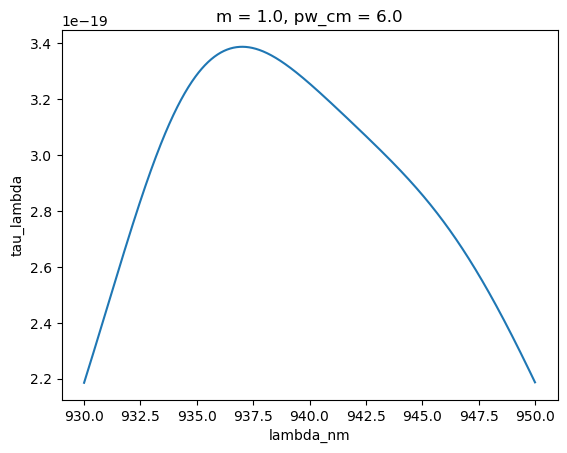

In [40]:
ds_hapi.tau_lambda.sel(m = 1, pw_cm = 6).plot()

# with continuum using pyarts

In [57]:
import os, sys, glob, pathlib

def _find_dirs():
    cand = []
    cp = os.environ.get("CONDA_PREFIX", "")
    if cp:
        cand += glob.glob(os.path.join(cp, "share", "arts-cat-data*"))
        cand += glob.glob(os.path.join(cp, "share", "arts-xml-data*"))
    home_cache = os.path.join(pathlib.Path.home(), ".cache", "pyarts")
    cand += glob.glob(os.path.join(home_cache, "arts-cat-data*"))
    cand += glob.glob(os.path.join(home_cache, "arts-xml-data*"))
    # Keep only directories, prefer highest version if multiple
    cand = [d for d in cand if os.path.isdir(d)]
    # Partition into cat/xml
    cat = sorted([d for d in cand if "arts-cat-data" in d])[-1:]  # latest if many
    xml = sorted([d for d in cand if "arts-xml-data" in d])[-1:]
    return cat, xml

cat, xml = _find_dirs()
if not (cat and xml):
    raise RuntimeError(
        "Could not locate arts-cat-data / arts-xml-data.\n"
        "Install them with:\n"
        "  mamba install -c rttools arts-cat-data arts-xml-data\n"
        "or run:  import pyarts; pyarts.cat.download.retrieve()  (then re-run this cell)"
    )

os.environ["ARTS_DATA_PATH"] = f"{cat[0]}:{xml[0]}"
print("ARTS_DATA_PATH set to:\n ", os.environ['ARTS_DATA_PATH'])

# sanity: check that the split line catalog exists
lines1 = os.path.join(cat[0], "lines")
if not os.path.isdir(lines1):
    raise RuntimeError(f"'lines' directory not found at: {lines1}")
print("Found lines directory:\n ", lines1)


RuntimeError: Could not locate arts-cat-data / arts-xml-data.
Install them with:
  mamba install -c rttools arts-cat-data arts-xml-data
or run:  import pyarts; pyarts.cat.download.retrieve()  (then re-run this cell)

In [55]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Spectral H2O LUT around 940 nm using ARTS (pyarts), with MT_CKD continuum if available.
- Groups continuum tags with H2O as a single species entry.
- Uses a fresh Workspace per attempt to avoid state mismatches.

Output: lut_940nm_spectral_ARTS_MTCKD_xr.nc
  - T_lambda(lambda_nm, m, pw_cm)   # spectral transmittance
  - tau_lambda(lambda_nm, m, pw_cm) # spectral optical depth
  - sigma_m2(lambda_nm)             # cross-section [m^2/molecule]
"""

import os
from pathlib import Path
import numpy as np
import xarray as xr
from scipy.constants import N_A, k as k_B, c
import pyarts
from pyarts.workspace import Workspace

# ----------------------------
# Config
# ----------------------------
LAM_MIN_NM, LAM_MAX_NM, DLAM_NM = 930.0, 950.0, 0.02
M_GRID  = np.linspace(1.0, 5.0, 9)            # airmass
PW_GRID = np.r_[np.linspace(0.1, 2.0, 20), np.linspace(2.5, 6.0, 15)]  # cm
T_K, P_HPA = 288.0, 1013.25
P_PA = P_HPA * 100.0
COL_PER_CM_PW = (10.0 / 0.018) * N_A         # ≈ 3.346e26 molecules m^-2 per cm
CKD_VERS = ["400", "350", "320", "252"]      # 4.0, 3.5, 3.2, 2.5.2

# ----------------------------
# Helpers
# ----------------------------
def ensure_catalogs():
    pyarts.cat.download.retrieve()

def find_lines_dir():
    # Prefer logical path; ARTS search path resolves "lines/" when registered.
    return "lines/"

def build_sigma_once(ckd_ver):
    """
    Try to build sigma(λ) for a specific MT_CKD version (or None for lines-only).
    Returns (sigma_m2, chosen_desc) or raises on failure.
    """
    ws = Workspace()

    # --- Species: group continuum with H2O in ONE entry
    if ckd_ver is None:
        species = ["H2O"]
        spec_desc = "lines-only"
    else:
        species = [f"H2O, H2O-SelfContCKDMT{ckd_ver}, H2O-ForeignContCKDMT{ckd_ver}"]
        spec_desc = f"MT_CKD {ckd_ver}"

    ws.abs_speciesSet(species=species)

    # --- Line catalog: reset & read; cutoff so continuum handles far wings
    ws.abs_lines_per_speciesEmpty()
    ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename=find_lines_dir())
    ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)  # 25 cm^-1 ≈ 750 GHz

    # --- Agenda from current species set
    ws.propmat_clearsky_agendaAuto()

    # --- Scalar RT, thermodynamic state
    ws.stokes_dim = 1
    ws.jacobian_quantities = []
    ws.rtp_mag = []
    ws.rtp_los = []
    ws.rtp_pos = []
    ws.rtp_nlte = pyarts.arts.EnergyLevelMap()

    lam_nm = np.arange(LAM_MIN_NM, LAM_MAX_NM + DLAM_NM, DLAM_NM)
    lam_nm_desc = lam_nm[::-1]
    ws.f_grid = np.ascontiguousarray(c / (lam_nm_desc * 1e-9))  # Hz (increasing)

    ws.rtp_temperature = np.array([T_K])
    ws.rtp_pressure    = np.array([P_PA])

    # VMR list must match number of species entries (here 1)
    ws.rtp_vmr = [np.array([0.01])]  # arbitrary; cancels in σ = α / n_H2O

    # --- LBL check AFTER setting species, lines, grids, and state
    ws.lbl_checkedCalc()

    # --- Execute agenda & compute σ
    ws.AgendaExecute(ws.propmat_clearsky_agenda)

    alpha_m_inv_desc = np.asarray(ws.propmat_clearsky.value).reshape(-1)  # m^-1
    n_tot  = P_PA / (k_B * T_K)   # m^-3
    n_h2o  = 0.01 * n_tot
    sigma_m2_desc = alpha_m_inv_desc / n_h2o
    sigma_m2 = sigma_m2_desc[::-1]  # back to increasing λ

    return sigma_m2, spec_desc, lam_nm

def build_lut_from_sigma(lam_nm, sigma_m2):
    L, M, W = lam_nm.size, M_GRID.size, PW_GRID.size
    sigma_b = sigma_m2.reshape(L, 1, 1)
    m_b     = M_GRID.reshape(1, M, 1)
    pw_b    = PW_GRID.reshape(1, 1, W)
    Ncol_slant = m_b * (COL_PER_CM_PW * pw_b)
    tau_lambda = sigma_b * Ncol_slant
    T_lambda   = np.exp(-tau_lambda)
    ds = xr.Dataset(
        data_vars=dict(
            T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
            tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
            sigma_m2=(('lambda_nm',), sigma_m2),
        ),
        coords=dict(lambda_nm=lam_nm, m=M_GRID, pw_cm=PW_GRID),
    )
    return ds

# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    ensure_catalogs()

    # Try CKD versions, then lines-only
    tried = []
    sigma_m2 = None
    chosen_desc = None
    lam_nm = None
    for ver in CKD_VERS + [None]:
        try:
            sigma_m2, chosen_desc, lam_nm = build_sigma_once(ver)
            break
        except Exception as e:
            tried.append((ver, repr(e)))
            continue

    if sigma_m2 is None:
        msg = "Failed to compute σ(λ). Tried: " + ", ".join([f"CKD {v}" if v else "lines-only" for v,_ in tried])
        msg += f". Last error: {tried[-1][1] if tried else 'unknown'}"
        raise RuntimeError(msg)

    ds = build_lut_from_sigma(lam_nm, sigma_m2)
    ds.attrs.update({
        "desc": "Spectral H2O direct-beam transmittance & optical depth around 940 nm.",
        "spectroscopy": f"ARTS LBL (H2O lines) + {chosen_desc}; 25 cm^-1 line cutoff.",
        "T_K": float(T_K),
        "P_hPa": float(P_HPA),
        "note": "VMR used only to form σ = α / n_H2O; retrieval uses PW grid.",
    })
    out_nc = "lut_940nm_spectral_ARTS_MTCKD_xr.nc"
    ds.to_netcdf(out_nc)
    print(ds)
    print(f"Wrote {out_nc}")
    print(f"Using spectroscopy: {ds.attrs['spectroscopy']}")


RuntimeError: Failed to compute σ(λ). Tried: CKD 400, CKD 350, CKD 320, CKD 252, lines-only. Last error: AttributeError("'Workspace' object has no attribute 'abs_lines_per_speciesEmpty'")

In [56]:
import pyarts, os
from pyarts.workspace import Workspace
pyarts.cat.download.retrieve()
ws = Workspace()
print("ARTS_DATA_PATH:", os.environ.get("ARTS_DATA_PATH"))
print("abs_species BEFORE:", [str(x) for x in ws.abs_species.value])
ws.abs_speciesSet(species=["H2O, H2O-SelfContCKDMT400, H2O-ForeignContCKDMT400"])
print("abs_species AFTER :", [str(x) for x in ws.abs_species.value], "len:", len(ws.abs_species.value))
ws.abs_lines_per_speciesEmpty()
ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename="lines/")
print("len(abs_lines_per_species):", len(ws.abs_lines_per_species.value))


ARTS_DATA_PATH: None


RuntimeError: User Error: not is_initialized()
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/build/src/python_interface/py_auto_interface.cc"
Function Name: "Python::WorkspaceVariable::operator Python::WorkspaceVariablesVariant() const"
Line Number:   243
Column Number: 3
Please follow these instructions to correct your error:
Not initialized: abs_species

In [54]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Build a spectral H2O-only LUT around 940 nm using ARTS (pyarts),
including MT_CKD continuum if available (auto-detect version).

Output: lut_940nm_spectral_ARTS_MTCKD_xr.nc
  - T_lambda(lambda_nm, m, pw_cm)   # spectral transmittance
  - tau_lambda(lambda_nm, m, pw_cm) # spectral optical depth
  - sigma_m2(lambda_nm)             # cross-section [m^2/molecule]
"""

import os
from pathlib import Path
import numpy as np
import xarray as xr
from scipy.constants import N_A, k as k_B, c
import pyarts
from pyarts.workspace import Workspace

# ----------------------------
# Config
# ----------------------------
LAM_MIN_NM, LAM_MAX_NM, DLAM_NM = 930.0, 950.0, 0.02
M_GRID  = np.linspace(1.0, 5.0, 9)            # airmass
PW_GRID = np.r_[np.linspace(0.1, 2.0, 20), np.linspace(2.5, 6.0, 15)]  # cm
T_K, P_HPA = 288.0, 1013.25
P_PA = P_HPA * 100.0
COL_PER_CM_PW = (10.0 / 0.018) * N_A         # molecules m^-2 per cm PW (~3.346e26)

# Candidate continuum versions (descending preference)
CKD_VERS = ["400", "350", "320", "252"]      # 4.0, 3.5, 3.2, 2.5.2

# ----------------------------
# Helpers
# ----------------------------
def ensure_catalogs():
    """Download/register ARTS catalogs & data paths if needed."""
    pyarts.cat.download.retrieve()

def find_lines_dir():
    """Return a lines/ directory path ending with '/', robust to env setups."""
    # Try ARTS search path first (preferred)
    try:
        return "lines/"
    except Exception:
        pass
    # Fallback: resolve an absolute path from ARTS_DATA_PATH or cache
    adp = os.environ.get("ARTS_DATA_PATH", "")
    candidates = [Path(p) for p in adp.split(os.pathsep) if p and "arts-cat-data" in p]
    if not candidates:
        candidates = list((Path.home()/".cache"/"pyarts").glob("arts-cat-data*"))
    if not candidates:
        raise RuntimeError("Could not locate arts-cat-data; ARTS_DATA_PATH not set?")
    return str((candidates[0] / "lines").resolve()) + "/"

def set_abs_species_with_ckd(ws: Workspace):
    """Try to set H2O lines + MT_CKD (self, foreign). Return chosen version or None."""
    for v in CKD_VERS:
        tags = [ "H2O", f"H2O-SelfContCKDMT{v}", f"H2O-ForeignContCKDMT{v}" ]
        try:
            ws.abs_speciesSet(species=tags)
            # If this later fails at AgendaExecute with a "No data" error, we'll catch & try next.
            return v
        except Exception:
            continue
    # Lines only fallback (no continuum)
    ws.abs_speciesSet(species=["H2O"])
    return None

def read_lines_catalog(ws: Workspace, basename: str):
    """Read split line catalog; basename must end with '/'."""
    try:
        ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename=basename)
    except RuntimeError as e:
        raise RuntimeError(f"Reading line catalog failed at '{basename}': {e}")

def build_sigma(ws: Workspace, lam_nm: np.ndarray):
    """
    Compute σ(λ) [m^2/molecule] from ARTS at single (P,T,VMR) state.
    Ensures f_grid is strictly increasing; flips results back to increasing λ.
    """
    lam_nm_desc = lam_nm[::-1]
    ws.f_grid = np.ascontiguousarray(c / (lam_nm_desc * 1e-9))  # Hz, increasing

    # Single-state thermodynamics for broadening/partition
    ws.rtp_temperature = np.array([T_K])
    ws.rtp_pressure    = np.array([P_PA])

    # rtp_vmr must match abs_species length (lines + any continua)
    n_tags = len(ws.abs_species.value)
    vmr_h2o = 0.01  # arbitrary; cancels in σ = α / n_H2O
    ws.rtp_vmr = [np.array([vmr_h2o]) for _ in range(n_tags)]

    # LBL sanity check AFTER grids/state/species are set
    ws.lbl_checkedCalc()

    # Execute clearsky absorption agenda
    ws.AgendaExecute(ws.propmat_clearsky_agenda)

    # α(f) [m^-1] aligned with f_grid
    alpha_m_inv_desc = np.asarray(ws.propmat_clearsky.value).reshape(-1)

    # σ = α / n_H2O
    n_tot  = P_PA / (k_B * T_K)    # m^-3
    n_h2o  = vmr_h2o * n_tot
    sigma_m2_desc = alpha_m_inv_desc / n_h2o
    sigma_m2 = sigma_m2_desc[::-1] # back to increasing λ
    return sigma_m2

def build_lut_from_sigma(lam_nm, sigma_m2, m_grid, pw_grid):
    """Form spectral LUT T_lambda(λ,m,PW) and tau_lambda."""
    L, M, W = lam_nm.size, m_grid.size, pw_grid.size
    sigma_b = sigma_m2.reshape(L, 1, 1)
    m_b     = m_grid.reshape(1, M, 1)
    pw_b    = pw_grid.reshape(1, 1, W)
    Ncol_slant = m_b * (COL_PER_CM_PW * pw_b)
    tau_lambda = sigma_b * Ncol_slant
    T_lambda   = np.exp(-tau_lambda)
    ds = xr.Dataset(
        data_vars=dict(
            T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
            tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
            sigma_m2=(('lambda_nm',), sigma_m2),
        ),
        coords=dict(lambda_nm=lam_nm, m=m_grid, pw_cm=pw_grid),
    )
    return ds

# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    ensure_catalogs()
    ws = Workspace()

    # Try continuum versions in order
    chosen_ckd = set_abs_species_with_ckd(ws)

    # Read lines catalog (with trailing slash) and set cutoff
    lines_base = find_lines_dir()
    read_lines_catalog(ws, basename=lines_base)
    ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)  # 25 cm^-1 ≈ 750 GHz

    # Build clearsky agenda from current species list
    ws.propmat_clearsky_agendaAuto()

    # Spectral grid (increasing λ)
    lam_nm = np.arange(LAM_MIN_NM, LAM_MAX_NM + DLAM_NM, DLAM_NM)

    # Try to compute σ(λ). If the chosen CKD lacks data, fall back to older version or lines-only.
    sigma_m2 = None
    tried = []
    versions_to_try = [chosen_ckd] if chosen_ckd else [None]
    # If we selected 4.0 but data is missing, try 3.5→3.2→2.5.2; if we started with None, that's lines-only.
    if chosen_ckd:
        fallback_order = [v for v in CKD_VERS if v != chosen_ckd]
        versions_to_try += fallback_order + [None]  # None triggers lines-only

    for v in versions_to_try:
        try:
            if v is not None:
                # Re-set species to this CKD version
                ws.abs_speciesSet(species=["H2O",
                                           f"H2O-SelfContCKDMT{v}",
                                           f"H2O-ForeignContCKDMT{v}"])
            else:
                ws.abs_speciesSet(species=["H2O"])  # lines only
            # Rebuild agenda after changing species
            ws.propmat_clearsky_agendaAuto()
            sigma_m2 = build_sigma(ws, lam_nm)
            chosen_ckd = v  # record what actually worked
            break
        except Exception as e:
            tried.append((v, repr(e)))
            continue

    if sigma_m2 is None:
        raise RuntimeError(
            "Failed to compute σ(λ). Tried: "
            + ", ".join([f"CKD {v}" if v else "lines-only" for v,_ in tried])
            + f". Last error: {tried[-1][1] if tried else 'unknown'}"
        )

    # Build LUT and save
    ds = build_lut_from_sigma(lam_nm, sigma_m2, M_GRID, PW_GRID)
    # Add metadata
    meta = {
        "desc": "Spectral H2O direct-beam transmittance & optical depth around 940 nm.",
        "spectroscopy": (
            "ARTS LBL (H2O lines)"
            + (f" + MT_CKD {chosen_ckd}" if chosen_ckd else " (no continuum)")
            + "; 25 cm^-1 line cutoff."
        ),
        "T_K": float(T_K),
        "P_hPa": float(P_HPA),
        "note": "VMR used only to form σ = α / n_H2O; retrieval uses PW grid."
    }
    ds.attrs.update(meta)
    out_nc = "lut_940nm_spectral_ARTS_MTCKD_xr.nc"
    ds.to_netcdf(out_nc)
    print(ds)
    print(f"Wrote {out_nc}")
    if not chosen_ckd:
        print("WARNING: MT_CKD continuum was not found; result is lines-only (bias risk in 940-nm band).")
    else:
        print(f"Using MT_CKD version: {chosen_ckd}")


RuntimeError: Failed to compute σ(λ). Tried: CKD 400, CKD 350, CKD 320, CKD 252, lines-only. Last error: RuntimeError('User Error: abs_lines_per_species.nelem() not_eq abs_species.nelem()\nError is found at:\nFilename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/m_checked.cc"\nFunction Name: "void lbl_checkedCalc(Index&, const ArrayOfArrayOfAbsorptionLines&, const ArrayOfArrayOfSpeciesTag&, const SpeciesIsotopologueRatios&, const Verbosity&)"\nLine Number:   746\nColumn Number: 3\nPlease follow these instructions to correct your error:\nabs_lines_per_species and abs_species must have same length.\nInstead len(abs_lines_per_species) = 3 and len(abs_species) = 1\n')

In [53]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Spectral H2O LUT around 940 nm with MT_CKD (self & foreign) using pyarts.

Output: lut_940nm_spectral_ARTS_MTCKD_xr.nc
  - T_lambda(lambda_nm, m, pw_cm)   # spectral transmittance (H2O-only)
  - tau_lambda(lambda_nm, m, pw_cm) # spectral optical depth (H2O-only)
  - sigma_m2(lambda_nm)             # cross-section per molecule [m^2/molecule]
"""

import os
from pathlib import Path
import numpy as np
import xarray as xr
from scipy.constants import N_A, k as k_B, c
import pyarts
from pyarts.workspace import Workspace

# ----------------------------
# 0) Catalogs & workspace
# ----------------------------
pyarts.cat.download.retrieve()        # ensure catalogs & search path are set
ws = Workspace()

# ----------------------------
# 1) Absorbers: H2O lines + MT_CKD continuum
# ----------------------------
species_primary  = ["H2O", "H2O-SelfContCKDMT400", "H2O-ForeignContCKDMT400"]
species_fallback = ["H2O", "H2O-SelfContCKDMT",   "H2O-ForeignContCKDMT"]

def set_abs_species(ws):
    try:
        ws.abs_speciesSet(species=species_primary)
    except Exception:
        ws.abs_speciesSet(species=species_fallback)

set_abs_species(ws)

# Read HITRAN split catalog (trailing slash required). Fallback: absolute path.
def read_lines_catalog(ws):
    try:
        ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename="lines/")
        return
    except RuntimeError:
        adp = os.environ.get("ARTS_DATA_PATH", "")
        candidates = [Path(p) for p in adp.split(os.pathsep) if p and "arts-cat-data" in p]
        if not candidates:
            candidates = list((Path.home()/".cache"/"pyarts").glob("arts-cat-data*"))
        if not candidates:
            raise
        lines_dir = str((candidates[0] / "lines").resolve()) + "/"
        ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename=lines_dir)

read_lines_catalog(ws)

# Far-wing cutoff so continuum handles wings consistently: 25 cm^-1 ≈ 750 GHz
ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)

# Build clearsky propagation agenda (based on current species/continua)
ws.propmat_clearsky_agendaAuto()

# Minimal initializations
ws.stokes_dim = 1
ws.jacobian_quantities = []
ws.rtp_mag = []
ws.rtp_los = []
ws.rtp_pos = []
ws.rtp_nlte = pyarts.arts.EnergyLevelMap()  # LTE

# ----------------------------
# 2) Spectral grid (λ increasing) → ARTS f_grid (Hz increasing)
# ----------------------------
lam_min_nm, lam_max_nm, dlam_nm = 930.0, 950.0, 0.02
lam_nm = np.arange(lam_min_nm, lam_max_nm + dlam_nm, dlam_nm)

lam_nm_desc = lam_nm[::-1]                # ARTS requires increasing frequency
f_grid = c / (lam_nm_desc * 1e-9)         # Hz, strictly increasing
ws.f_grid = np.ascontiguousarray(f_grid)

# ----------------------------
# 3) Thermodynamic state for spectroscopy widths (single state)
# ----------------------------
T_K   = 288.0
P_hPa = 1013.25
P_Pa  = P_hPa * 100.0
ws.rtp_temperature = np.array([T_K])
ws.rtp_pressure    = np.array([P_Pa])

# --- VMR setup (must match abs_species length) ---
vmr_h2o = 0.01  # arbitrary; cancels in sigma = alpha / n_H2O
n_tags = len(ws.abs_species.value)  # e.g., 3 for ["H2O", "H2O-SelfCont...", "H2O-ForeignCont..."]

# Provide one Vector per tag; each vector length must match rtp grid length (here 1)
ws.rtp_vmr = [np.array([vmr_h2o]) for _ in range(n_tags)]

# (optional) sanity check
print("len(abs_species) =", n_tags, "len(rtp_vmr) =", len(ws.rtp_vmr.value))


# *** REQUIRED: LBL sanity check after grids/state/species are set ***
ws.lbl_checkedCalc()

# ----------------------------
# 4) Execute clearsky absorption agenda and get cross-section
# ----------------------------
ws.AgendaExecute(ws.propmat_clearsky_agenda)

# α(f): m^-1 aligned with f_grid
alpha_m_inv_desc = np.asarray(ws.propmat_clearsky.value).reshape(-1)

# σ = α / n_H2O  (m^2/molecule)
n_tot  = P_Pa / (k_B * T_K)     # m^-3
n_h2o  = vmr_h2o * n_tot        # m^-3
sigma_m2_desc = alpha_m_inv_desc / n_h2o

# Flip back to match λ increasing
sigma_m2 = sigma_m2_desc[::-1]             # shape = (len(lam_nm),)

# ----------------------------
# 5) Build spectral LUT T_lambda(λ, m, PW)
# ----------------------------
m_vals  = np.linspace(1.0, 5.0, 9)  # airmass 1..5
pw_vals = np.concatenate([np.linspace(0.1, 2.0, 20),
                          np.linspace(2.5, 6.0, 15)])  # PW [cm]

# 1 cm PW = 10 kg m^-2  ⇒ molecules m^-2 per cm PW:
from scipy.constants import N_A
COL_PER_CM_PW = (10.0 / 0.018) * N_A       # ≈ 3.346e26 molecules m^-2 per cm

L, M, W = lam_nm.size, m_vals.size, pw_vals.size
sigma_b = sigma_m2.reshape(L, 1, 1)
m_b     = m_vals.reshape(1, M, 1)
pw_b    = pw_vals.reshape(1, 1, W)

Ncol_slant = m_b * (COL_PER_CM_PW * pw_b)  # molecules m^-2
tau_lambda = sigma_b * Ncol_slant          # unitless
T_lambda   = np.exp(-tau_lambda)

# ----------------------------
# 6) Package to xarray and save
# ----------------------------
ds = xr.Dataset(
    data_vars=dict(
        T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
        tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
        sigma_m2=(('lambda_nm',), sigma_m2),
    ),
    coords=dict(
        lambda_nm=lam_nm,
        m=m_vals,
        pw_cm=pw_vals
    ),
    attrs=dict(
        desc="Spectral H2O-only direct-beam transmittance & optical depth around 940 nm.",
        spectroscopy="ARTS LBL (H2O lines) + MT_CKD self & foreign continuum; 25 cm^-1 cutoff.",
        T_K=float(T_K),
        P_hPa=float(P_hPa)
    )
)

out_nc = "lut_940nm_spectral_ARTS_MTCKD_xr.nc"
ds.to_netcdf(out_nc)
print(ds)
print(f"Wrote {out_nc}")

# ----------------------------
# 7) (Optional) later: convolve with any SRF
# ----------------------------
def band_T_from_srf(ds_in, lam_srf_nm, srf, m, pw_cm):
    import numpy as _np
    from scipy.interpolate import interp1d as _interp1d
    lam = ds_in.lambda_nm.values
    f = _interp1d(lam_srf_nm, srf, kind='linear', bounds_error=False, fill_value=0.0)
    w = f(lam)
    w[w < 0] = 0.0
    area = _np.trapz(w, lam)
    if area <= 0:
        raise ValueError("SRF integrates to zero.")
    w /= area
    T_spec = ds_in.T_lambda.se_


len(abs_species) = 3 len(rtp_vmr) = 3


RuntimeError: User Error: agenda_failed
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/m_agenda.cc"
Function Name: "void AgendaExecute(Workspace&, const Agenda&, const Verbosity&)"
Line Number:   85
Column Number: 3
Please follow these instructions to correct your error:
Run-time error in agenda: propmat_clearsky_agenda
Run-time error in method: propmat_clearskyAddPredefined
User Error:
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/predefined/predef_data.h"
Function Name: "const T& Absorption::PredefinedModel::Model::get() const [with T = Absorption::PredefinedModel::MT_CKD400::WaterData]"
Line Number:   57
Column Number: 5
Please follow these instructions to correct your error:
Cannot find data for continua with error: User Error: data.find(T::key) == data.end()
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/predefined/predef_data.h"
Function Name: "const T& Absorption::PredefinedModel::Model::get() const [with T = Absorption::PredefinedModel::MT_CKD400::WaterData]"
Line Number:   54
Column Number: 5
Please follow these instructions to correct your error:
No data

In [51]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Spectral H2O LUT around 940 nm with MT_CKD (self & foreign) using pyarts.

Outputs: lut_940nm_spectral_ARTS_MTCKD_xr.nc
  - T_lambda(lambda_nm, m, pw_cm)   # spectral transmittance (H2O-only)
  - tau_lambda(lambda_nm, m, pw_cm) # spectral optical depth (H2O-only)
  - sigma_m2(lambda_nm)             # cross-section per molecule [m^2/molecule]

Notes:
  - Single (T,P) state for line widths (swap to layer-resolved later).
  - ARTS needs f_grid strictly increasing ⇒ we reverse λ for ARTS, then flip back.
"""

import os
from pathlib import Path
import numpy as np
import xarray as xr
from scipy.constants import N_A, k as k_B, c
import pyarts
from pyarts.workspace import Workspace

# ----------------------------
# 0) Catalogs & workspace
# ----------------------------
pyarts.cat.download.retrieve()        # ensure catalogs & search path are set
ws = Workspace()

# ----------------------------
# 1) Absorbers: H2O lines + MT_CKD continuum
# ----------------------------
species_primary  = ["H2O", "H2O-SelfContCKDMT400", "H2O-ForeignContCKDMT400"]
species_fallback = ["H2O", "H2O-SelfContCKDMT",   "H2O-ForeignContCKDMT"]

def set_abs_species(ws):
    try:
        ws.abs_speciesSet(species=species_primary)
    except Exception:
        ws.abs_speciesSet(species=species_fallback)

set_abs_species(ws)

# Read HITRAN split catalog (trailing slash required). Fallback: absolute path.
def read_lines_catalog(ws):
    try:
        ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename="lines/")
        return
    except RuntimeError:
        adp = os.environ.get("ARTS_DATA_PATH", "")
        candidates = [Path(p) for p in adp.split(os.pathsep) if p and "arts-cat-data" in p]
        if not candidates:
            candidates = list((Path.home()/".cache"/"pyarts").glob("arts-cat-data*"))
        if not candidates:
            raise
        lines_dir = str((candidates[0] / "lines").resolve()) + "/"
        ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename=lines_dir)

read_lines_catalog(ws)

# Use a 25 cm^-1 cutoff (~750 GHz) so far wings go to the continuum
ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)

# Build clearsky propagation agenda (based on current species/continua)
ws.propmat_clearsky_agendaAuto()

# Minimal initializations
ws.stokes_dim = 1
ws.jacobian_quantities = []
ws.rtp_mag = []
ws.rtp_los = []
ws.rtp_pos = []
ws.rtp_nlte = pyarts.arts.EnergyLevelMap()  # LTE

# ----------------------------
# 2) Spectral grid (λ increasing) → ARTS f_grid (Hz increasing)
# ----------------------------
lam_min_nm, lam_max_nm, dlam_nm = 930.0, 950.0, 0.02
lam_nm = np.arange(lam_min_nm, lam_max_nm + dlam_nm, dlam_nm)

lam_nm_desc = lam_nm[::-1]                # ARTS requires increasing frequency
f_grid = c / (lam_nm_desc * 1e-9)         # Hz, strictly increasing
ws.f_grid = np.ascontiguousarray(f_grid)

# ----------------------------
# 3) Thermodynamic state for spectroscopy widths (single state)
# ----------------------------
T_K   = 288.0
P_hPa = 1013.25
P_Pa  = P_hPa * 100.0
ws.rtp_temperature = np.array([T_K])
ws.rtp_pressure    = np.array([P_Pa])
ws.rtp_vmr         = [np.array([0.01])]   # arbitrary 1% H2O; cancels in sigma = alpha/n_H2O

# *** REQUIRED: LBL sanity check before using lines ***
ws.lbl_checkedCalc()

# ----------------------------
# 4) Execute clearsky absorption agenda and get cross-section
# ----------------------------
ws.AgendaExecute(ws.propmat_clearsky_agenda)

# α(f): m^-1 aligned with f_grid
alpha_m_inv_desc = np.asarray(ws.propmat_clearsky.value).reshape(-1)

# σ = α / n_H2O  (m^2/molecule)
n_tot  = P_Pa / (k_B * T_K)     # m^-3
vmr_h2o = float(ws.rtp_vmr[0][0])
n_h2o = vmr_h2o * n_tot
sigma_m2_desc = alpha_m_inv_desc / n_h2o

# Flip back to match λ increasing
sigma_m2 = sigma_m2_desc[::-1]             # shape = (len(lam_nm),)

# ----------------------------
# 5) Build spectral LUT T_lambda(λ, m, PW)
# ----------------------------
m_vals  = np.linspace(1.0, 5.0, 9)  # airmass 1..5
pw_vals = np.concatenate([np.linspace(0.1, 2.0, 20),
                          np.linspace(2.5, 6.0, 15)])  # PW [cm]

# 1 cm PW = 10 kg m^-2  ⇒ molecules m^-2 per cm PW:
COL_PER_CM_PW = (10.0 / 0.018) * N_A       # ≈ 3.346e26 molecules m^-2 per cm

L, M, W = lam_nm.size, m_vals.size, pw_vals.size
sigma_b = sigma_m2.reshape(L, 1, 1)
m_b     = m_vals.reshape(1, M, 1)
pw_b    = pw_vals.reshape(1, 1, W)

Ncol_slant = m_b * (COL_PER_CM_PW * pw_b)  # molecules m^-2
tau_lambda = sigma_b * Ncol_slant          # unitless
T_lambda   = np.exp(-tau_lambda)

# ----------------------------
# 6) Package to xarray and save
# ----------------------------
ds = xr.Dataset(
    data_vars=dict(
        T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
        tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
        sigma_m2=(('lambda_nm',), sigma_m2),
    ),
    coords=dict(
        lambda_nm=lam_nm,
        m=m_vals,
        pw_cm=pw_vals
    ),
    attrs=dict(
        desc="Spectral H2O-only direct-beam transmittance & optical depth around 940 nm.",
        spectroscopy="ARTS LBL (H2O lines) + MT_CKD self & foreign continuum; 25 cm^-1 cutoff.",
        T_K=float(T_K),
        P_hPa=float(P_hPa)
    )
)

out_nc = "lut_940nm_spectral_ARTS_MTCKD_xr.nc"
ds.to_netcdf(out_nc)
print(ds)
print(f"Wrote {out_nc}")

# ----------------------------
# 7) (Optional) later: convolve with any SRF
# ----------------------------
def band_T_from_srf(ds_in, lam_srf_nm, srf, m, pw_cm):
    import numpy as _np
    from scipy.interpolate import interp1d as _interp1d
    lam = ds_in.lambda_nm.values
    f = _interp1d(lam_srf_nm, srf, kind='linear', bounds_error=False, fill_value=0.0)
    w = f(lam)
    w[w < 0] = 0.0
    area = _np.trapz(w, lam)
    if area <= 0:
        raise ValueError("SRF integrates to zero.")
    w /= area
    T_spec = ds_in.T_lambda.sel(m=m, pw_cm=pw_cm, method='nearest').values
    return float(_np.trapz(T_spec * w, lam))


RuntimeError: User Error: agenda_failed
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/m_agenda.cc"
Function Name: "void AgendaExecute(Workspace&, const Agenda&, const Verbosity&)"
Line Number:   85
Column Number: 3
Please follow these instructions to correct your error:
Run-time error in agenda: propmat_clearsky_agenda
Run-time error in method: propmat_clearskyAddLines
User Error: rtp_vmr.nelem() not_eq abs_species.nelem()
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/m_abs.cc"
Function Name: "void propmat_clearskyAddLines(PropagationMatrix&, StokesVector&, ArrayOfPropagationMatrix&, ArrayOfStokesVector&, const Vector&, const ArrayOfArrayOfSpeciesTag&, const ArrayOfSpeciesTag&, const ArrayOfRetrievalQuantity&, const ArrayOfArrayOfAbsorptionLines&, const SpeciesIsotopologueRatios&, const Numeric&, const Numeric&, const EnergyLevelMap&, const Vector&, const Index&, const Index&, const Numeric&, const Numeric&, const String&, const Index&, const Verbosity&)"
Line Number:   855
Column Number: 3
Please follow these instructions to correct your error:
*rtp_vmr* must match *abs_species*

In [49]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Build a spectral H2O-only LUT around 940 nm with MT_CKD continuum using pyarts.

Outputs:
  - lut_940nm_spectral_ARTS_MTCKD_xr.nc
      variables:
        T_lambda(lambda_nm, m, pw_cm)   # spectral transmittance
        tau_lambda(lambda_nm, m, pw_cm) # spectral optical depth
        sigma_m2(lambda_nm)             # cross-section per molecule [m^2/molecule]
      attrs: spectroscopy, T_K, P_hPa

Notes:
  - Direct-beam (clear-sky) absorption only; no Rayleigh/aerosol/ozone.
  - Single (T,P) state for spectroscopy widths (swap to layer-resolved later).
  - Frequency grid must be strictly increasing in ARTS; we reverse λ for ARTS, then flip back.
  - Continuum tags use MT_CKD 4.0 names; a fallback is provided.

Env:
  conda create -n arts python=3.11 -y
  conda activate arts
  mamba install -c rttools pyarts typhon -y
  python this_script.py
"""
import os
from pathlib import Path
import numpy as np
import xarray as xr
from scipy.constants import N_A, k as k_B, c
import pyarts
from pyarts.workspace import Workspace

# ----------------------------
# 0) Catalogs & workspace
# ----------------------------
# Ensure ARTS data/catalogs are present and registered (downloads if missing)
pyarts.cat.download.retrieve()

ws = Workspace()

# ----------------------------
# 1) Absorbers: H2O lines + MT_CKD (self & foreign)
# ----------------------------
# Primary tags (MT_CKD 4.0)
species_primary = ["H2O", "H2O-SelfContCKDMT400", "H2O-ForeignContCKDMT400"]
# Fallback tags (if your catalog uses generic names)
species_fallback = ["H2O", "H2O-SelfContCKDMT", "H2O-ForeignContCKDMT"]

def set_abs_species(ws):
    try:
        ws.abs_speciesSet(species=species_primary)
    except Exception:
        ws.abs_speciesSet(species=species_fallback)

set_abs_species(ws)

# Read split line catalog (HITRAN-based). ARTS needs the directory *with* a trailing slash.
def read_lines_catalog(ws):
    try:
        ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename="lines/")
        return
    except RuntimeError:
        # Fallback: try to locate the absolute 'lines/' dir inside arts-cat-data
        adp = os.environ.get("ARTS_DATA_PATH", "")
        candidates = []
        for p in adp.split(os.pathsep):
            if p and "arts-cat-data" in p:
                candidates.append(Path(p))
        if not candidates:
            candidates = list((Path.home() / ".cache" / "pyarts").glob("arts-cat-data*"))
        if not candidates:
            raise
        lines_dir = str((candidates[0] / "lines").resolve()) + "/"
        ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename=lines_dir)

read_lines_catalog(ws)

# Use a 25 cm^-1 cutoff (~750 GHz) so the continuum handles the far wings consistently
ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)

# Build the clearsky propagation agenda from the current species/continua
ws.propmat_clearsky_agendaAuto()

# Minimal initializations for scalar RT
ws.stokes_dim = 1
ws.jacobian_quantities = []
ws.rtp_mag = []
ws.rtp_los = []
ws.rtp_pos = []
ws.rtp_nlte = pyarts.arts.EnergyLevelMap()  # LTE

# ----------------------------
# 2) Spectral grid (λ increasing), then build ARTS f_grid (Hz increasing)
# ----------------------------
lam_min_nm, lam_max_nm, dlam_nm = 930.0, 950.0, 0.02
lam_nm = np.arange(lam_min_nm, lam_max_nm + dlam_nm, dlam_nm)

lam_nm_desc = lam_nm[::-1]                 # ARTS needs f increasing → λ decreasing
f_grid = c / (lam_nm_desc * 1e-9)          # Hz, strictly increasing
ws.f_grid = np.ascontiguousarray(f_grid)

# ----------------------------
# 3) Thermodynamic state for spectroscopy widths (single state)
# ----------------------------
T_K   = 288.0
P_hPa = 1013.25
P_Pa  = P_hPa * 100.0
ws.rtp_temperature = np.array([T_K])
ws.rtp_pressure    = np.array([P_Pa])
ws.rtp_vmr         = [np.array([0.01])]    # 1% H2O (arbitrary; cancels in sigma = alpha / n_H2O)

# ----------------------------
# 4) Execute clearsky absorption agenda and get cross-section
# ----------------------------
ws.AgendaExecute(ws.propmat_clearsky_agenda)

# Absorption coefficient α(f) aligned with f_grid (units: m^-1)
alpha_m_inv_desc = np.asarray(ws.propmat_clearsky.value).reshape(-1)

# Cross-section per molecule σ = α / n_H2O (units: m^2/molecule)
n_tot = P_Pa / (k_B * T_K)        # m^-3
vmr_h2o = float(ws.rtp_vmr[0][0])
n_h2o = vmr_h2o * n_tot           # m^-3
sigma_m2_desc = alpha_m_inv_desc / n_h2o

# Flip back to match λ increasing
sigma_m2 = sigma_m2_desc[::-1]    # shape = (len(lam_nm),)

# ----------------------------
# 5) Build spectral LUT T_lambda(λ, m, PW)
# ----------------------------
m_vals  = np.linspace(1.0, 5.0, 9)  # airmass 1..5
pw_vals = np.concatenate([np.linspace(0.1, 2.0, 20),
                          np.linspace(2.5, 6.0, 15)])  # PW [cm]

# Column conversion: 1 cm PW = 10 kg m^-2; molecules m^-2 per cm PW
COL_PER_CM_PW = (10.0 / 0.018) * N_A    # ≈ 3.346e26 molecules m^-2 per cm

L = lam_nm.size
M = m_vals.size
W = pw_vals.size

sigma_b = sigma_m2.reshape(L, 1, 1)
m_b     = m_vals.reshape(1, M, 1)
pw_b    = pw_vals.reshape(1, 1, W)

Ncol_slant = m_b * (COL_PER_CM_PW * pw_b)   # molecules m^-2
tau_lambda = sigma_b * Ncol_slant           # unitless
T_lambda   = np.exp(-tau_lambda)

# ----------------------------
# 6) Package to xarray and save
# ----------------------------
ds = xr.Dataset(
    data_vars=dict(
        T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
        tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
        sigma_m2=(('lambda_nm',), sigma_m2),
    ),
    coords=dict(
        lambda_nm=lam_nm,
        m=m_vals,
        pw_cm=pw_vals
    ),
    attrs=dict(
        desc="Spectral H2O-only direct-beam transmittance & optical depth around 940 nm.",
        spectroscopy="ARTS LBL (H2O lines) + MT_CKD self & foreign continuum; 25 cm^-1 cutoff.",
        T_K=float(T_K),
        P_hPa=float(P_hPa)
    )
)

out_nc = "lut_940nm_spectral_ARTS_MTCKD_xr.nc"
ds.to_netcdf(out_nc)
print(ds)
print(f"Wrote {out_nc}")

# ----------------------------
# 7) (Optional) helper to convolve later with any SRF
# ----------------------------
def band_T_from_srf(ds_in, lam_srf_nm, srf, m, pw_cm):
    """Convolve spectral T(λ) with an arbitrary SRF (normalize in λ)."""
    import numpy as _np
    from scipy.interpolate import interp1d as _interp1d
    lam = ds_in.lambda_nm.values
    f = _interp1d(lam_srf_nm, srf, kind='linear', bounds_error=False, fill_value=0.0)
    w = f(lam)
    w[w < 0] = 0.0
    area = _np.trapz(w, lam)
    if area <= 0:
        raise ValueError("SRF integrates to zero.")
    w /= area
    T_spec = ds_in.T_lambda.sel(m=m, pw_cm=pw_cm, method='nearest').values
    return float(_np.trapz(T_spec * w, lam))

# Example usage (commented):
# lam_srf_nm = np.array([...]); srf = np.array([...])
# T_band = band_T_from_srf(ds, lam_srf_nm, srf, m=2.0, pw_cm=1.5)
# print("Band T940 =", T_band)


RuntimeError: User Error: agenda_failed
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/m_agenda.cc"
Function Name: "void AgendaExecute(Workspace&, const Agenda&, const Verbosity&)"
Line Number:   85
Column Number: 3
Please follow these instructions to correct your error:
Run-time error in agenda: propmat_clearsky_agenda
Run-time error in method: propmat_clearskyAddLines
User Error: not lbl_checked
Error is found at:
Filename:      "/home/runner/miniconda3/envs/pyarts-build/conda-bld/pyarts_1761128829101/work/src/m_abs.cc"
Function Name: "void propmat_clearskyAddLines(PropagationMatrix&, StokesVector&, ArrayOfPropagationMatrix&, ArrayOfStokesVector&, const Vector&, const ArrayOfArrayOfSpeciesTag&, const ArrayOfSpeciesTag&, const ArrayOfRetrievalQuantity&, const ArrayOfArrayOfAbsorptionLines&, const SpeciesIsotopologueRatios&, const Numeric&, const Numeric&, const EnergyLevelMap&, const Vector&, const Index&, const Index&, const Numeric&, const Numeric&, const String&, const Index&, const Verbosity&)"
Line Number:   853
Column Number: 3
Please follow these instructions to correct your error:
Must check LBL calculations

In [48]:
# env: conda activate arts
# pip installs (if needed): python -m pip install xarray numpy scipy

import numpy as np
import xarray as xr
import pyarts
from pyarts.workspace import Workspace
from scipy.constants import N_A, k as k_B

# ----------------------------
# 1) Workspace + spectroscopic data (H2O lines + MT_CKD continuum)
# ----------------------------
# Make sure ARTS catalog/paths are set; downloads if missing.
pyarts.cat.download.retrieve()  # ARTS >=2.6 convenience helper  (downloads/sets search path)  [see ARTS 2.6 paper]
ws = Workspace()

# Select: H2O lines + MT_CKD self & foreign continuum (MT_CKD version comes from your installed data)
# If your arts-xml-data uses slightly different tag names, see the note just below.
ws.abs_speciesSet(
    species=["H2O", "H2O-SelfContCKDMT400", "H2O-ForeignContCKDMT400"]
)
# Read split line catalog (HITRAN-based) and set the 25 cm^-1 cutoff => 25 cm^-1 = 750e9 Hz
ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename="lines/")
ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)

# Build the appropriate absorption agenda automatically from abs_species
ws.propmat_clearsky_agendaAuto()

# Minimal required initializations
ws.stokes_dim = 1             # scalar
ws.jacobian_quantities = []   # no jacobians
ws.rtp_mag = []               # no magnetic field
ws.rtp_los = []               # not used here
ws.rtp_pos = []               # not used here
ws.rtp_nlte = pyarts.arts.EnergyLevelMap()  # LTE

# ----------------------------
# 2) Spectral grid (λ: 930–950 nm) and single-state T,P for sigma(λ)
#    (You can swap in layer-resolved profiles later; this builds the spectral LUT shape first.)
# ----------------------------
lam_min_nm, lam_max_nm, dlam_nm = 930.0, 950.0, 0.02
lam_nm = np.arange(lam_min_nm, lam_max_nm + dlam_nm, dlam_nm)

# For ARTS: make frequency strictly increasing ⇒ use λ in *descending* order
lam_nm_desc = lam_nm[::-1]
f_grid = c / (lam_nm_desc * 1e-9)   # Hz, strictly increasing
ws.f_grid = np.ascontiguousarray(f_grid)

# Representative thermodynamic state for sigma(λ) (affects broadening/partition)
T_K   = 288.0
P_hPa = 1013.25
P_Pa  = P_hPa * 100.0
ws.rtp_temperature = np.array([T_K])
ws.rtp_pressure    = np.array([P_Pa])

# Put some H2O in the box (any positive VMR works; we'll divide it back out)
ws.rtp_vmr = [np.array([0.01])]   # 1% H2O

# ----------------------------
# 3) Compute absorption coefficient and convert to cross-section per molecule
#    propmat_clearsky [m^-1] = sigma(λ) [m^2/molec] * n_H2O [molec/m^3]
# ----------------------------
# Execute the clearsky propagation agenda at this (P,T,VMR, f_grid)
# Run clearsky absorption at this state
ws.propmat_clearsky_agendaExecute()

# ARTS returns absorption aligned with f_grid (which we built from lam_nm_desc)
alpha_m_inv_desc = np.asarray(ws.propmat_clearsky.value).reshape(-1)  # m^-1

# Convert to cross-section per molecule
T_K   = 288.0
P_hPa = 1013.25
P_Pa  = P_hPa * 100.0
n_tot = P_Pa / (k_B * T_K)           # m^-3
vmr_h2o = ws.rtp_vmr[0][0]           # e.g., 0.01
n_h2o = vmr_h2o * n_tot              # m^-3
sigma_m2_desc = alpha_m_inv_desc / n_h2o

# Flip back to match lam_nm (increasing λ)
sigma_m2 = sigma_m2_desc[::-1]        # (unit check: m^-1 / m^-3 = m^2)

# ----------------------------
# 4) Build spectral LUT T_lambda(λ, m, PW)
# ----------------------------
m_vals  = np.linspace(1.0, 5.0, 9)  # airmass
pw_vals = np.concatenate([np.linspace(0.1, 2.0, 20),
                          np.linspace(2.5, 6.0, 15)])  # cm PW

# Column conversion: 1 cm PW = 10 kg m^-2; molecules m^-2 per cm PW:
COL_PER_CM_PW = (10.0 / 0.018) * N_A   # ≈ 3.346e26 molec m^-2 per cm

L = lam_nm.size
M = m_vals.size
W = pw_vals.size
sigma_b = sigma_m2.reshape(L, 1, 1)
m_b     = m_vals.reshape(1, M, 1)
pw_b    = pw_vals.reshape(1, 1, W)

Ncol_slant = m_b * (COL_PER_CM_PW * pw_b)      # molecules m^-2
tau_lambda = sigma_b * Ncol_slant               # unitless
T_lambda   = np.exp(-tau_lambda)

# ----------------------------
# 5) Package to xarray (spectral-first, convolve later with any SRF)
# ----------------------------
ds = xr.Dataset(
    data_vars=dict(
        T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
        tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
        sigma_m2=(('lambda_nm',), sigma_m2),
    ),
    coords=dict(
        lambda_nm=lam_nm,
        m=m_vals,
        pw_cm=pw_vals
    ),
    attrs=dict(
        desc="Spectral H2O-only direct-beam transmittance & optical depth around 940 nm.",
        spectroscopy="ARTS LBL (HITRAN-based) + MT_CKD self & foreign continuum; 25 cm^-1 cutoff.",
        T_K=float(T_K), P_hPa=float(P_hPa)
    )
)
ds.to_netcdf("lut_940nm_spectral_ARTS_MTCKD_xr.nc")
print(ds)
print("Wrote lut_940nm_spectral_ARTS_MTCKD_xr.nc")


AttributeError: 'Workspace' object has no attribute 'propmat_clearsky_agendaExecute'

In [46]:
# env: conda activate arts
# pip installs (if needed): python -m pip install xarray numpy scipy

import numpy as np
import xarray as xr
import pyarts
from pyarts.workspace import Workspace
from scipy.constants import N_A, k as k_B

# ----------------------------
# 1) Workspace + spectroscopic data (H2O lines + MT_CKD continuum)
# ----------------------------
# Make sure ARTS catalog/paths are set; downloads if missing.
pyarts.cat.download.retrieve()  # ARTS >=2.6 convenience helper  (downloads/sets search path)  [see ARTS 2.6 paper]
ws = Workspace()

# Select: H2O lines + MT_CKD self & foreign continuum (MT_CKD version comes from your installed data)
# If your arts-xml-data uses slightly different tag names, see the note just below.
ws.abs_speciesSet(
    species=["H2O", "H2O-SelfContCKDMT400", "H2O-ForeignContCKDMT400"]
)
# Read split line catalog (HITRAN-based) and set the 25 cm^-1 cutoff => 25 cm^-1 = 750e9 Hz
ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename="lines/")
ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)

# Build the appropriate absorption agenda automatically from abs_species
ws.propmat_clearsky_agendaAuto()

# Minimal required initializations
ws.stokes_dim = 1             # scalar
ws.jacobian_quantities = []   # no jacobians
ws.rtp_mag = []               # no magnetic field
ws.rtp_los = []               # not used here
ws.rtp_pos = []               # not used here
ws.rtp_nlte = pyarts.arts.EnergyLevelMap()  # LTE

# ----------------------------
# 2) Spectral grid (λ: 930–950 nm) and single-state T,P for sigma(λ)
#    (You can swap in layer-resolved profiles later; this builds the spectral LUT shape first.)
# ----------------------------
lam_min_nm, lam_max_nm, dlam_nm = 930.0, 950.0, 0.02
lam_nm = np.arange(lam_min_nm, lam_max_nm + dlam_nm, dlam_nm)

# ARTS uses frequency (Hz) internally; convenient helper: Kayser↔Hz. We'll set grid in wavenumber then convert.
kayser = 1e7 / lam_nm        # cm^-1
ws.f_grid = pyarts.arts.convert.kayser2freq(kayser)  # Hz

# Representative thermodynamic state for sigma(λ) (affects broadening/partition)
T_K   = 288.0
P_hPa = 1013.25
P_Pa  = P_hPa * 100.0
ws.rtp_temperature = np.array([T_K])
ws.rtp_pressure    = np.array([P_Pa])

# Put some H2O in the box (any positive VMR works; we'll divide it back out)
ws.rtp_vmr = [np.array([0.01])]   # 1% H2O

# ----------------------------
# 3) Compute absorption coefficient and convert to cross-section per molecule
#    propmat_clearsky [m^-1] = sigma(λ) [m^2/molec] * n_H2O [molec/m^3]
# ----------------------------
# Execute the clearsky propagation agenda at this (P,T,VMR, f_grid)
ws.propmat_clearsky_agendaExecute()

# Extract scalar absorption coefficient (K_11) from the propagation matrix:
# In stokes_dim=1, propmat_clearsky contains just the extinction coeff. Use .value for the numeric array.
# Shape is (nfreq,); if not, squeeze as needed.
alpha_m_inv = np.asarray(ws.propmat_clearsky.value).reshape(-1)  # m^-1

# Number density (ideal gas) & H2O number density
n_tot = P_Pa / (k_B * T_K)                         # m^-3
vmr_h2o = ws.rtp_vmr[0][0]                         # scalar 0.01
n_h2o = vmr_h2o * n_tot                            # m^-3

# Cross-section per molecule [m^2/molecule]
sigma_m2 = alpha_m_inv / n_h2o                     # (unit check: m^-1 / m^-3 = m^2)

# ----------------------------
# 4) Build spectral LUT T_lambda(λ, m, PW)
# ----------------------------
m_vals  = np.linspace(1.0, 5.0, 9)  # airmass
pw_vals = np.concatenate([np.linspace(0.1, 2.0, 20),
                          np.linspace(2.5, 6.0, 15)])  # cm PW

# Column conversion: 1 cm PW = 10 kg m^-2; molecules m^-2 per cm PW:
COL_PER_CM_PW = (10.0 / 0.018) * N_A   # ≈ 3.346e26 molec m^-2 per cm

L = lam_nm.size
M = m_vals.size
W = pw_vals.size
sigma_b = sigma_m2.reshape(L, 1, 1)
m_b     = m_vals.reshape(1, M, 1)
pw_b    = pw_vals.reshape(1, 1, W)

Ncol_slant = m_b * (COL_PER_CM_PW * pw_b)      # molecules m^-2
tau_lambda = sigma_b * Ncol_slant               # unitless
T_lambda   = np.exp(-tau_lambda)

# ----------------------------
# 5) Package to xarray (spectral-first, convolve later with any SRF)
# ----------------------------
ds = xr.Dataset(
    data_vars=dict(
        T_lambda=(('lambda_nm','m','pw_cm'), T_lambda),
        tau_lambda=(('lambda_nm','m','pw_cm'), tau_lambda),
        sigma_m2=(('lambda_nm',), sigma_m2),
    ),
    coords=dict(
        lambda_nm=lam_nm,
        m=m_vals,
        pw_cm=pw_vals
    ),
    attrs=dict(
        desc="Spectral H2O-only direct-beam transmittance & optical depth around 940 nm.",
        spectroscopy="ARTS LBL (HITRAN-based) + MT_CKD self & foreign continuum; 25 cm^-1 cutoff.",
        T_K=float(T_K), P_hPa=float(P_hPa)
    )
)
ds.to_netcdf("lut_940nm_spectral_ARTS_MTCKD_xr.nc")
print(ds)
print("Wrote lut_940nm_spectral_ARTS_MTCKD_xr.nc")


AttributeError: module 'pyarts.arts.convert' has no attribute 'kayser2freq'

In [43]:
import numpy as np
import pyarts

# 1) Ensure catalog paths are available in this session
pyarts.cat.download.retrieve()  # downloads (if needed) and sets ARTS data search path

# 2) Workspace
ws = pyarts.workspace.Workspace()

# 3) Species incl. MT_CKD 4.0 self/foreign continuum
ws.abs_speciesSet(species=["H2O", "H2O-SelfContCKDMT400", "H2O-ForeignContCKDMT400"])
ws.ReadXML(ws.predefined_model_data, "model/mt_ckd_4.0/H2O.xml")

# 4) Read HITRAN-based split catalog (the key change is the trailing slash)
ws.abs_lines_per_speciesReadSpeciesSplitCatalog(basename="lines/")
ws.abs_lines_per_speciesCutoff(option="ByLine", value=750e9)  # 25 cm^-1

# 5) Proceed with lbl_checkedCalc / propmat_clearsky_agendaAuto as before
ws.lbl_checkedCalc()
ws.propmat_clearsky_agendaAuto()


## for the convolution with filter function

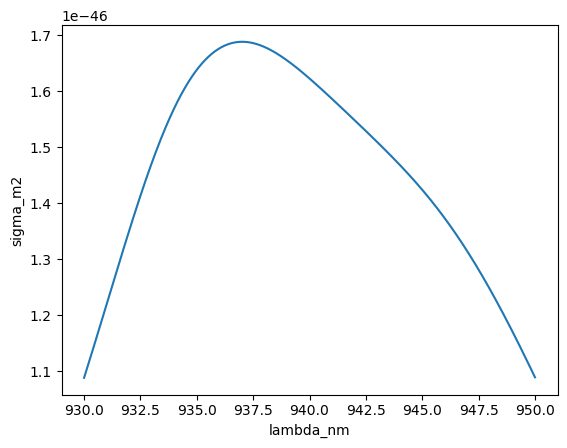

In [38]:
import numpy as np, xarray as xr
from scipy.interpolate import interp1d

ds = xr.load_dataset("lut_940nm_spectral_ARTS_MTCKD_xr.nc")
lam = ds.lambda_nm.values

def band_T_from_srf(ds, lam_srf_nm, srf, m, pw_cm):
    f = interp1d(lam_srf_nm, srf, kind='linear', bounds_error=False, fill_value=0.0)
    w = f(lam)
    w[w<0] = 0.0
    area = np.trapz(w, lam)
    if area <= 0: raise ValueError("SRF integrates to zero.")
    w /= area
    T_spec = ds.T_lambda.sel(m=m, pw_cm=pw_cm, method='nearest').values
    return float(np.trapz(T_spec * w, lam))


In [26]:
# 940-nm PW LUT using HITRAN HAPI (hitran-api) + xarray
# -----------------------------------------------------
# Conda env:   conda activate arts
# Install:     python -m pip install --upgrade hitran-api xarray numpy pandas scipy
#
# Outputs:
#  - xr.DataArray T_940[m, pw_cm] (band transmittance, H2O-only)
#  - xr.DataArray tau_940[m, pw_cm] (band optical depth, H2O-only)
#  - (a_fit, b_fit) for ln T ≈ -a*(m*PW)^b over a non-saturated mask
#
# Notes:
#  - This is a line-only calculation. For publication-grade accuracy,
#    add the MT_CKD continuum (or switch engine to pyarts/LBLRTM later).
#  - Use your measured SRF for the 940-nm channel to set coefficients for YOUR instrument.

import numpy as np
import xarray as xr
from scipy.interpolate import interp1d
from scipy.constants import N_A
from hapi import db_begin, fetch, absorptionCoefficient_Voigt

# ----------------------------
# Config
# ----------------------------
# Spectral window (covers the whole band to capture line wings)
lam_center_nm = 940.0
half_span_nm  = 10.0          # +-10 nm window; adjust if your SRF has wider tails
lam_min_nm    = lam_center_nm - half_span_nm
lam_max_nm    = lam_center_nm + half_span_nm
dlam_nm       = 0.02          # wavelength step for integration (~0.02 nm)

# Atmos state for cross-section calculation (affects line widths + partitioning)
T_K  = 288.0      # representative temperature
P_hPa = 1013.25   # representative pressure (cross-section weakly P/T dependent in near-IR)

# Grids for LUT
m_vals  = np.linspace(1.0, 5.0, 9)  # solar airmass 1..5
pw_vals = np.concatenate([np.linspace(0.1, 2.0, 20), np.linspace(2.5, 6.0, 15)])  # PW [cm]

# ----------------------------
# Instrument SRF
# Replace with your measured SRF by passing lam_srf_nm, srf arrays to build_lut()
# ----------------------------
def gaussian_srf(lam_nm, lam0_nm, fwhm_nm):
    sigma = fwhm_nm / (2*np.sqrt(2*np.log(2)))
    return np.exp(-0.5*((lam_nm - lam0_nm)/sigma)**2)

def default_srf(lam_nm):
    srf = gaussian_srf(lam_nm, lam_center_nm, fwhm_nm=10.0)  # your channel FWHM
    # Normalize to unit area in wavelength space
    srf /= np.trapezoid(srf, lam_nm)
    return srf

# ----------------------------
# Column conversions
# 1 cm PW = 10 kg m^-2 of water
# Number column (molec m^-2) = (10 / 0.018) * N_A * PW_cm
# ----------------------------
COL_PER_CM_PW = (10.0 / 0.018) * N_A  # ≈ 3.345e27 molecules m^-2 per cm PW

# ----------------------------
# HITRAN pull (H2O, main isotopologue) and cross-section on our wavelength grid
# ----------------------------
def get_sigma_on_lambda_grid(lam_nm, T=T_K, P=P_hPa):
    """
    Returns sigma_m2(lam_nm): absorption cross-section per molecule [m^2/molecule]
    computed from HITRAN HAPI Voigt absorption coefficient at (T, P).
    """
    # Convert wavelength bounds to wavenumber [cm^-1]
    lam_m = lam_nm * 1e-9
    wnum_grid = (1.0/lam_m) / 100.0  # m^-1 -> cm^-1
    numin, numax = float(wnum_grid.min()), float(wnum_grid.max())

    # Download/cache HITRAN lines (H2O molecule_id=1, iso_id=1 → 1H2-16O)
    db_begin('hitran_db')
    fetch('H2O_930_950', 1, 1, numin, numax)

    # Absorption coefficient k(nu) in HITRAN units (cm^-1) for number density in molecule/cm^3
    nu, k_cm_inv = absorptionCoefficient_Voigt(
        SourceTables='H2O_930_950',
        Environment={'T': T, 'p': P},   # K, hPa
        HITRAN_units=True
    )

    # Convert k → sigma (cm^2/molecule): k = sigma * n  => sigma = k / n
    # Ideal gas number density in molecule/cm^3
    n_cm3 = 2.6867805e19 * (P/1013.25) * (273.15/T)
    sigma_cm2 = k_cm_inv / n_cm3

    # Interpolate sigma from HITRAN wavenumber grid to our wavelength grid
    f_sigma = interp1d(nu, sigma_cm2, kind='linear',
                       bounds_error=False, fill_value="extrapolate")
    sigma_cm2_on_wn = f_sigma(wnum_grid)

    # Convert to m^2/molecule
    sigma_m2 = sigma_cm2_on_wn * 1e-4
    return sigma_m2

# ----------------------------
# Band transmittance with SRF (wavelength-space convolution)
# ----------------------------
def band_T_from_sigma(lam_nm, srf_norm, sigma_m2, m, pw_cm):
    """
    Compute band-averaged transmittance:
        T_band = ∫ exp(-sigma * (m*Ncol)) * SRF(lam) dλ
    with SRF normalized to unit area in λ.
    """
    Ncol = COL_PER_CM_PW * pw_cm  # molecules m^-2 (vertical)
    tau_lambda = sigma_m2 * (m * Ncol)
    T_lambda = np.exp(-tau_lambda)
    return np.trapezoid(T_lambda * srf_norm, lam_nm)

# ----------------------------
# Build LUT (xarray) — returns T_940[m, pw_cm] and tau_940[m, pw_cm]
# ----------------------------
def build_lut(m_vals, pw_vals, lam_srf_nm=None, srf=None, T=T_K, P=P_hPa):
    # Wavelength grid for integration
    lam_nm = np.arange(lam_min_nm, lam_max_nm + dlam_nm, dlam_nm)

    # Instrument SRF
    if lam_srf_nm is None or srf is None:
        srf_use = default_srf(lam_nm)
        lam_use = lam_nm
    else:
        # Resample user SRF onto lam_nm and renormalize
        f_srf = interp1d(lam_srf_nm, srf, kind='linear',
                         bounds_error=False, fill_value=0.0)
        srf_use = f_srf(lam_nm)
        srf_use[srf_use < 0] = 0
        srf_use /= np.trapezoid(srf_use, lam_nm)
        lam_use = lam_nm

    # Cross-section σ(λ)
    sigma_m2 = get_sigma_on_lambda_grid(lam_use, T=T, P=P)

    # Allocate arrays
    M, W = len(m_vals), len(pw_vals)
    T_band = np.empty((M, W), dtype=float)

    # Fill LUT
    for i, m in enumerate(m_vals):
        for j, pw in enumerate(pw_vals):
            T_band[i, j] = band_T_from_sigma(lam_use, srf_use, sigma_m2, m, pw)

    # xarray containers
    T_da = xr.DataArray(
        T_band,
        coords={'m': m_vals, 'pw_cm': pw_vals},
        dims=('m', 'pw_cm'),
        name='T_940',
        attrs={
            'desc': 'H2O-only band transmittance at 940-nm MFRSR channel',
            'center_nm': lam_center_nm,
            'fwhm_nm': 10.0,
            'T_K': T,
            'P_hPa': P,
            'note': 'Line-only Voigt from HITRAN via hitran-api; no MT_CKD continuum.'
        }
    )
    tau_da = xr.apply_ufunc(lambda x: -np.log(np.clip(x, 1e-12, 1.0)),
                            T_da, dask='allowed').rename('tau_940')
    tau_da.attrs.update(T_da.attrs)
    tau_da.attrs['desc'] = 'H2O-only band optical depth at 940-nm MFRSR channel'
    return T_da, tau_da

# ----------------------------
# Power-law fit: ln T ≈ -a * (m*PW)^b  (avoid deep saturation)
# ----------------------------
def fit_power_law(T_da, m_vals, pw_vals, Tmin=0.2):
    mm, pp = np.meshgrid(m_vals, pw_vals, indexing='ij')
    X = np.log((mm * pp).ravel())
    Y = np.log(np.clip(T_da.values.ravel(), 1e-12, 1.0))
    mask = (T_da.values.ravel() > Tmin)
    A = np.vstack([np.ones(mask.sum()), X[mask]]).T
    B = np.log(-Y[mask])  # log(-log T)
    a0, b = np.linalg.lstsq(A, B, rcond=None)[0]
    a = np.exp(a0)
    return a, b

# ----------------------------
# Run it
# ----------------------------
T_940, tau_940 = build_lut(m_vals, pw_vals)

# Fit a quick power-law (optional, for fast inversion)
a_fit, b_fit = fit_power_law(T_940, m_vals, pw_vals, Tmin=0.2)
print(f"Power-law: ln T ≈ -{a_fit:.3f} * (m*PW)^{b_fit:.3f}   (mask T > 0.2)")

# Persist to NetCDF for your retrieval code
ds = xr.Dataset({'T_940': T_940, 'tau_940': tau_940})
ds.to_netcdf("lut_940nm_h2o_HAPI_xr.nc")
print("Wrote lut_940nm_h2o_HAPI_xr.nc with variables: T_940[m,pw_cm], tau_940[m,pw_cm]")


Using hitran_db

H2O_930_950
                     Lines parsed: 4857

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O_930_950
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
Header written to hitran_db/H2O_930_950.header
END DOWNLOAD
                     Lines parsed: 4857
PROCESSED
{'air': 1.0}
5.855870 seconds elapsed for abscoef; nlines = 4857
Power-law: ln T ≈ -0.000 * (m*PW)^0.000   (mask T > 0.2)
Wrote 

sh: 1: getfattr: not found


In [27]:
ds

<xarray.Dataset> Size: 5kB
Dimensions:  (m: 9, pw_cm: 35)
Coordinates:
  * m        (m) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * pw_cm    (pw_cm) float64 280B 0.1 0.2 0.3 0.4 0.5 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    T_940    (m, pw_cm) float64 3kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    tau_940  (m, pw_cm) float64 3kB 1.11e-16 1.11e-16 ... 1.11e-16 1.11e-16

In [22]:
import numpy as np
from hapi import db_begin, fetch, absorptionCoefficient_Voigt

# 930–950 nm -> wavenumber bounds (cm^-1)
numin, numax = 10526.0, 10753.0  # 950 nm, 930 nm

db_begin('hitran_db')
# molecule 1 = H2O, isotopologue 1 = 1H2-16O
fetch('H2O_930_950', 1, 1, numin, numax)

# Build a fine, *uniform* wavenumber grid (cm^-1)
# 0.01 cm^-1 resolves Voigt-broadened lines nicely at 1 atm
nu_grid = np.arange(numin, numax, 0.01)

# Set a representative state; use lower pressure if you want to SEE line structure
# (e.g., 300–600 hPa). For retrieval work keep realistic pressures.
T = 288.0     # K
p = 1013.25   # hPa  (try 400.0 to visualize lines more sharply)
env = {'T': T, 'p': p}

# Ask HAPI to compute on OUR grid (key step!)
nu_cm1, k_cm1 = absorptionCoefficient_Voigt(
    SourceTables='H2O_930_950',
    Environment=env,
    WavenumberGrid=nu_grid,
    HITRAN_units=True
)

# 'nu' is cm^-1, 'k' is the absorption coefficient in cm^-1 for number density in molecule cm^-3
# Plot k vs nu to inspect structure (denser grid -> more features).
# --- pack into a convenient table ---
c = 2.99792458e8
loschmidt = 2.6867805e19  # molecules cm^-3 at 273.15 K, 1013.25 hPa
n_cm3 = loschmidt * (p_hPa/1013.25) * (273.15/T)           # molecules cm^-3
sigma_cm2 = k_cm1 / n_cm3                                   # cross-section per molecule

df = pd.DataFrame({
    "nu_cm^-1": nu_cm1,
    "lambda_nm": 1e7/nu_cm1,             # λ[nm] = 1e7 / ν[cm^-1]
    "k_cm^-1": k_cm1,
    "sigma_cm2_per_molecule": sigma_cm2,
})

# sort by wavelength (optional)
df = df.sort_values("lambda_nm").reset_index(drop=True)

Using hitran_db

H2O_930_950
                     Lines parsed: 4871

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O_930_950
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
  65536 bytes written to hitran_db/H2O_930_950.data
Header written to hitran_db/H2O_930_950.header
END DOWNLOAD
                     Lines parsed: 4871
PROCESSED
{'air': 1.0}
6.125663 seconds elapsed for abscoef; nlines = 4871


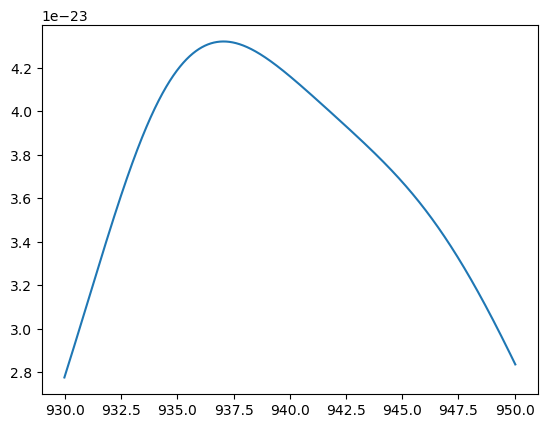

In [23]:
f,a = plt.subplots()
a.plot(df.lambda_nm,df['k_cm^-1'])